In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import global_funcs

In [2]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_valid = pd.read_csv('X_valid.csv')
Y_valid = pd.read_csv('Y_valid.csv')

### Teorema de Bayes

$P(y|X) = \frac{P(X|y).P(y)}{P(X)}$

* Para multiples caracteristicas del vector X

$X = (X_1,X_2,X_3.....X_n)$

$P(y|X) = \frac{P(X_1|y).P(X_2|y).P(X_3|y)...P(X_n|y).P(y)}{P(X)}$

* Seleccionar la clase con la probabilidad mas alta

$Y = argmax_y P(y|X) = argmax_y\frac{P(X_1|y).P(X_2|y).P(X_3|y)...P(X_n|y).P(y)}{P(X)}$

$Y = argmax_yP(X_1|y).P(X_2|y).P(X_3|y)...P(X_n|y).P(y)$

Tenemos para evitar desbordamiento en multiplicaciones con numeros muy pequeños:

$Y = argmax_ylog(P(X_1|y)).log(P(X_2|y)).log(P(X_3|y))...log(P(X_n|y)).log(P(y))$


In [3]:
classes = Y_train["passenger_survived"].unique()
classes

array([1, 0], dtype=int64)

In [4]:
#calcular medias,varianzas y prior para cada clase
means = []
variances = []
priors = []
for c in classes:
    f = X_train[np.array(Y_train)==c]
    mean = f.mean()
    var = f.var()
    prior = f.shape[0]/len(X_train)
    means.append(np.array(mean))
    variances.append(np.array(var))
    priors.append(np.array(prior))

#### Calculo de probabilidades condicionales

$P(X_i|Y) = \frac{1}{\sqrt{2\pi\sigma_y^2}}.exp(-\frac{(x_i-\mu)^2}{2\sigma_y})$


In [5]:
def getValueProb(c, x):
        mean = means[c]
        var = variances[c]
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [6]:
def getPosteriors(x):
    posts = []
    for i,c in enumerate(classes):
        prior = np.log(priors[i])#obtenemos la probabilidad de la clase
        post = np.sum(np.log(getValueProb(i,x)))
        post = post + prior
        posts.append(post)
    return classes[np.argmax(posts)]#retornamos la probabilidad mayor

In [7]:
def report(y_test,y_train,y_pred_test,y_pred_train):
    report = global_funcs.getReport(y_test,y_train,y_pred_test, y_pred_train)
    df_report = pd.DataFrame(report)
    return df_report

In [8]:
def predict(X_train, Y_train, X_test, Y_test):
        y_pred_test = [getPosteriors(x) for x in np.array(X_test)]
        y_pred_train = [getPosteriors(x) for x in np.array(X_train)]
        df_report = report(Y_test,Y_train,y_pred_test,y_pred_train)
        return df_report

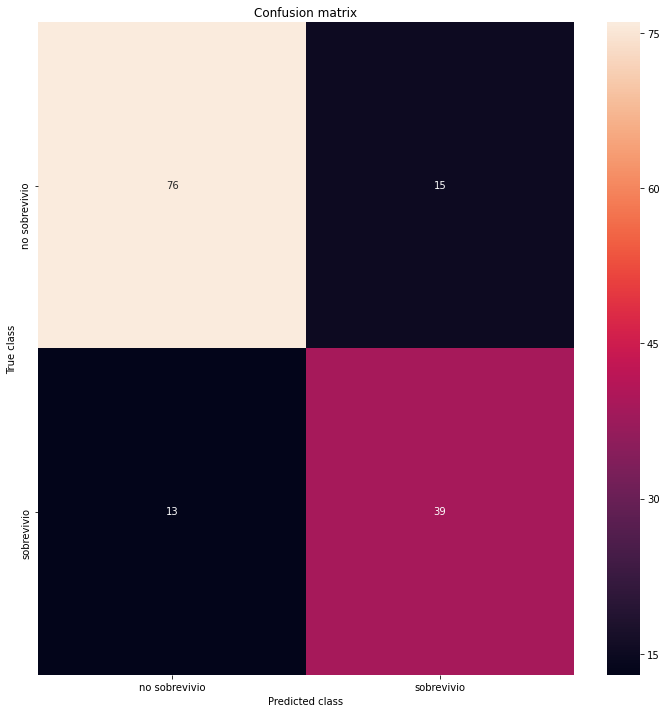

verdaderos positivos: 39
falsos positivos: 15
verdaderos negativos: 76
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.85      0.84      0.84        91
           1       0.72      0.75      0.74        52

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.81      0.80      0.80       143



,metrics_train,metrics_test
Accuracy,0.771529,0.804196
Precision,0.704036,0.722222
Recall:,0.710407,0.750000
F1_Score:,0.707207,0.735849


In [9]:
#primer modelo
modelo = predict(X_train,Y_train,X_valid,Y_valid)#entrenando el modelo
global_funcs.writeInExcel(modelo,"bitacora_naybe_bayes.xlsx",'implementación naive bayes likelihood')#escribiendo en bitacora excel
modelo

### Método con calculo de probabilidades conjuntas

Calcular probabilidades conjuntas

$Y = argmax_yP(X_1|y).P(X_2|y).P(X_3|y)...P(X_n|y).P(y)$

In [10]:
class NaiveBayes():
    #obtener las probabilidades a priori, de las clases y de las caracteristicas
    def fit(self,X,y):
        data = X.copy()
        data['passenger_survived'] = y['passenger_survived']
        self.priors = data.groupby('passenger_survived').size().div(len(data))#priors probabilities
        self.classes = sorted(y['passenger_survived'].unique()) #get classes
        self.probs_c = [[],[]]
        
        for d in data[X.columns.values]:
            a = data.groupby([d, 'passenger_survived']).size().div(len(data)).div(self.priors, axis=0, level='passenger_survived')
            #self.po = data.groupby(d).size().div(len(data))
            for i,p in enumerate(self.probs_c):
                pro = [a[i][0],a[i][1]]
                p.append(pro)
    
    #obtiene la probabilidad conjunta de las caracteristicas
    def predictPior(self,x,probs_priori):
        prob = 1
        for i,v in enumerate(probs_priori):
            prob *= v[x[i]]
        return prob
    
    #obtiene las predicciones de probabilidad para cada observacion
    def _predict(self,x):
        probabilities = []
        for i, c in enumerate(self.classes):
            prior = self.priors[i]
            prior_pred = self.predictPior(x,self.probs_c[i])
            probabilities.append(prior*prior_pred)
        probabilities = probabilities/sum(probabilities)#escalando datos para, distribución de probabilidades
        return self.classes[np.argmax(probabilities)],probabilities
    
    #obteien el total de probabilidades
    def predict(self,X):
        predictions = []
        probabilities = []
        for x in X:
            pred = self._predict(x)
            predictions.append(pred[0])
            probabilities.append(pred[1])
        return predictions,probabilities
    

In [11]:
nb = NaiveBayes()
nb.fit(X_train,Y_train)
y_pred_test = nb.predict(np.array(X_valid))[0]
y_pred_train = nb.predict(np.array(X_train))[0]

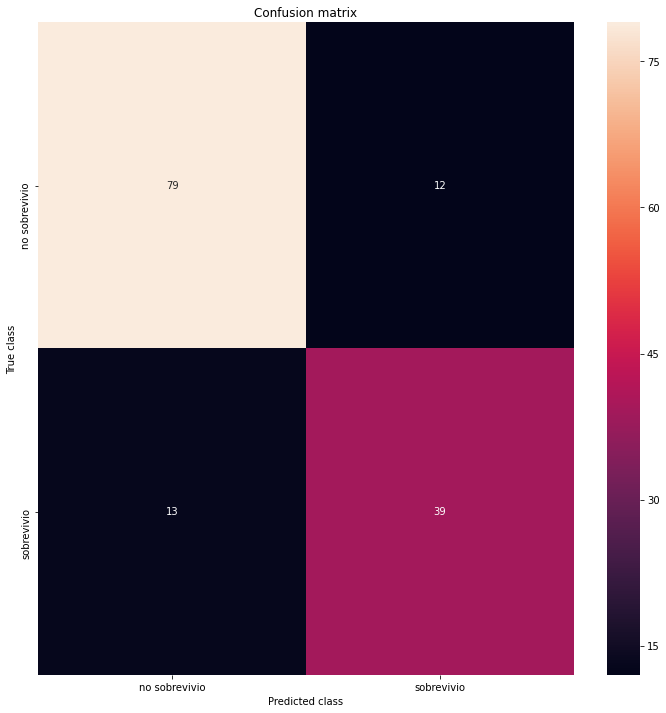

verdaderos positivos: 39
falsos positivos: 12
verdaderos negativos: 79
falsos negativos: 13
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        91
           1       0.76      0.75      0.76        52

    accuracy                           0.83       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.83      0.82       143



,metrics_train,metrics_test
Accuracy,0.778559,0.825175
Precision,0.723005,0.764706
Recall:,0.696833,0.750000
F1_Score:,0.709677,0.757282


In [12]:
modelo2 = report(Y_valid,Y_train,y_pred_test,y_pred_train)
global_funcs.writeInExcel(modelo2,"bitacora_naybe_bayes.xlsx",'implementación naive bayes solo probabilidades conjuntas')#escribiendo en bitacora excel
modelo2

## Conclusión
Con el modelo 2 obtenemos exactitud del 82% y recall de 75%, obtenemos mejores resultados que con el modelo 1
* al ser un modelo NO parametricos, tampoco necesita entrenamiento con gradient descent por ejemplo, unicamente para las pruebas bastará con el dataset de caracteristicas y classes, ya que son pocos datos, no nos preocupamos por el rendimiento.


* El dataset de caracteristicas y datos ya se encuentra exportado en un archivo.csv como X_train.csv y Y_train.csv respectivamente, que usaremos para el deployment, se exportara el escript.py de la clase NaibeBayes mas una función para obtener las predicciones.



In [13]:
test_x = pd.read_csv('X_test.csv')
test_y = pd.read_csv('Y_test.csv')
from sklearn import metrics

In [15]:
y_pred_t = nb.predict(np.array(test_x))[0]
metrics.accuracy_score(test_y,y_pred_t)

0.8044692737430168